In [17]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

### 1. Getting Orginal Data

In [76]:
#functions
def get_data(stock_name,start_date,end_date):
    data = yf.download(stock_name, start=start_date, end=end_date)
    return data

def add_time_step(data,start_step = 0):
    tmp = data.copy()
    tmp['Time_Step'] = np.arange(len(tmp.index))+start_step
    return tmp

def create_lag(data, i):
    tmp = data.copy()
    data['Lag_'+str(i)] = data['Close'].shift(i)
    return tmp

def plot_close(data,index = True):
    fig, ax = plt.subplots()
    if index:
        ax.plot(data.index, data.Close)
    else:
        ax.plot(data.Time_Step, data.Close)
    plt.show()
    return

[*********************100%%**********************]  1 of 1 completed


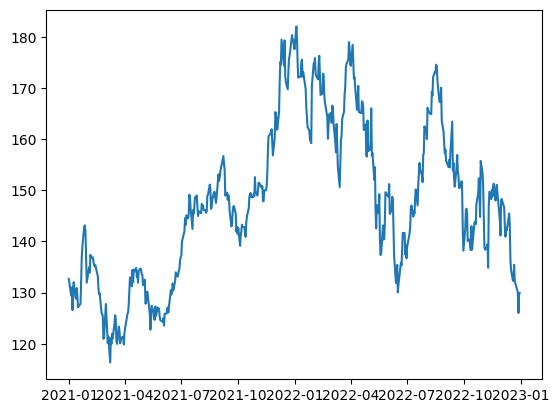

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,134.080002,134.740005,131.720001,132.690002,130.387222,99116600
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.164146,143301900
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.736374,97664900
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.402916,155088000
2021-01-07,128.360001,131.630005,127.860001,130.919998,128.647964,109578200


In [7]:
stock_name = 'AAPL'
start_date = '2020-12-31'
end_date = '2022-12-31'

train_data = get_data(stock_name,start_date,end_date)

plot_close(train_data)

train_data.head()

### 2. Getting Trend

In [78]:
#function
def plot_trend(data):
    fig, ax = plt.subplots()
    ax.plot('Time_Step', 'Close', data=data, color='0.75')
    ax = sns.regplot(x='Time_Step', y='Close', data=data, ci=None, scatter_kws=dict(color='0.25'))
    ax.set_title('Time PLot of Time Step')
    plt.show()

def get_trend(data, degree = 1):
    trend = np.polyfit(data['Time_Step'],data['Close'],degree)
    return trend

def remove_trend(data):
    remove_data = data.copy()
    trend = get_trend(data)
    remove_data.Close = remove_data.Close - remove_data.Time_Step * trend[0] - trend[1]
    return remove_data, trend

def remove_trend1(data,trend):
    remove_data = data.copy()
    remove_data.Close = remove_data.Close - remove_data.Time_Step * trend[0] - trend[1]
    return remove_data

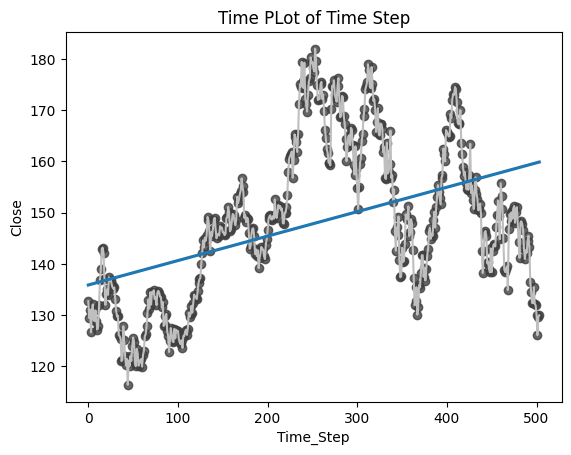

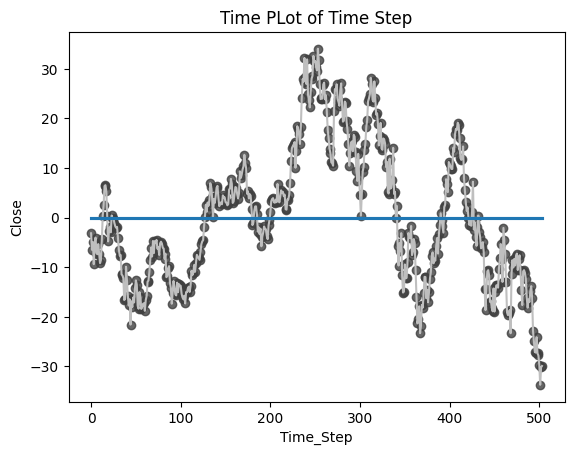

In [79]:
plot_trend(add_time_step(train_data))
remove_trend_data, trend = remove_trend(train_data)
plot_trend(remove_trend_data)

In [18]:
remove_trend_data.head()

,Open,High,Low,Close,Adj Close,Volume,Time_Step
Date,,,,,,,
2020-12-31,134.080002,134.740005,131.720001,-3.167557,130.387222,99116600,0
2021-01-04,133.520004,133.610001,126.760002,-6.495313,127.164146,143301900,1
2021-01-05,128.889999,131.740005,128.429993,-4.943078,128.736374,97664900,2
2021-01-06,127.720001,131.050003,126.379997,-9.400830,124.402916,155088000,3
2021-01-07,128.360001,131.630005,127.860001,-5.128587,128.647964,109578200,4


### 3. Getting Season

In [22]:
#functions
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

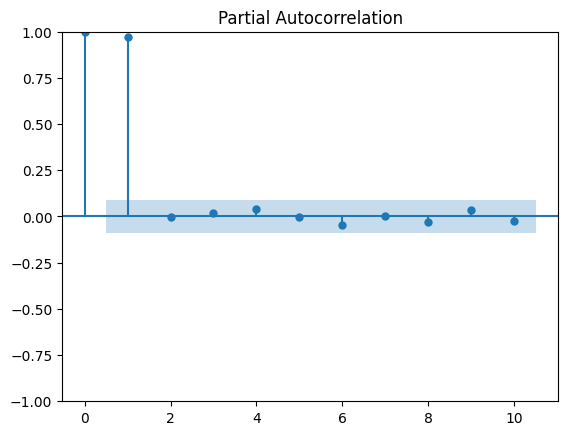

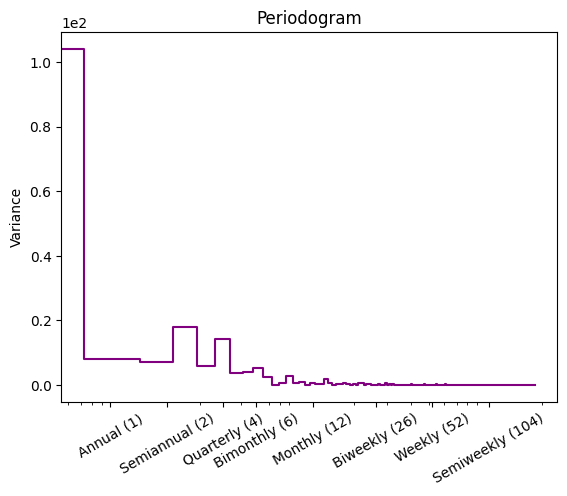

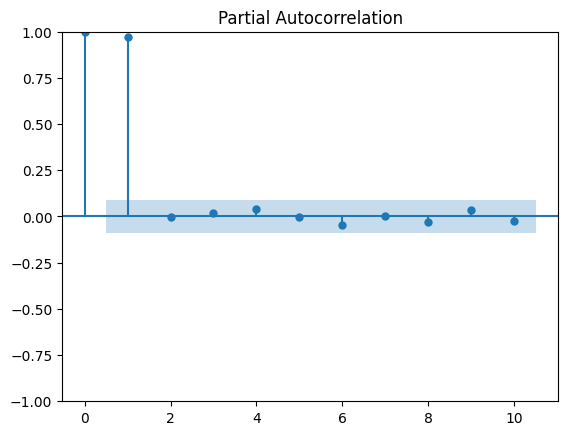

In [24]:
plot_periodogram(remove_trend_data.Close)
plot_pacf(remove_trend_data.Close, lags=10)

### 4. Training


In [91]:
#2 month
num_lag = 40
num_pred = 10
X_Train_cols = ['Time_Step']
y_Train_cols = ['Close']

for i in range(1,num_pred,1):
    y_Train_cols.append(f'Lag_{i}')

for i in range(num_pred,num_pred+num_lag,1):
    X_Train_cols.append(f'Lag_{i}')

print(X_Train_cols)
print(y_Train_cols)

['Time_Step', 'Lag_10', 'Lag_11', 'Lag_12', 'Lag_13', 'Lag_14', 'Lag_15', 'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22', 'Lag_23', 'Lag_24', 'Lag_25', 'Lag_26', 'Lag_27', 'Lag_28', 'Lag_29', 'Lag_30', 'Lag_31', 'Lag_32', 'Lag_33', 'Lag_34', 'Lag_35', 'Lag_36', 'Lag_37', 'Lag_38', 'Lag_39', 'Lag_40', 'Lag_41', 'Lag_42', 'Lag_43', 'Lag_44', 'Lag_45', 'Lag_46', 'Lag_47', 'Lag_48', 'Lag_49']
['Close', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7', 'Lag_8', 'Lag_9']


In [92]:
tmp = remove_trend_data[['Close','Time_Step']]
for i in range(1,num_lag+num_pred,1):
    create_lag(tmp,i)
tmp.dropna(inplace=True)
X = tmp[X_Train_cols]
y = tmp[y_Train_cols]

/var/folders/y4/8m7zvb3s42z21rz3sv9j00gr0000gn/T/ipykernel_47801/1649376569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lag_'+str(i)] = data['Close'].shift(i)
/var/folders/y4/8m7zvb3s42z21rz3sv9j00gr0000gn/T/ipykernel_47801/1649376569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lag_'+str(i)] = data['Close'].shift(i)
/var/folders/y4/8m7zvb3s42z21rz3sv9j00gr0000gn/T/ipykernel_47801/1649376569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()

,Time_Step,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,...,Lag_40,Lag_41,Lag_42,Lag_43,Lag_44,Lag_45,Lag_46,Lag_47,Lag_48,Lag_49
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-15,49,-9.930055,-16.412298,-16.634546,-12.226789,-11.669030,-11.481275,-7.563523,-7.675755,-6.498009,...,-7.377363,-5.349611,-7.391851,-7.164102,-4.046338,-5.128587,-9.400830,-4.943078,-6.495313,-3.167557
2021-03-16,50,-12.647810,-9.930055,-16.412298,-16.634546,-12.226789,-11.669030,-11.481275,-7.563523,-7.675755,...,-9.195124,-7.377363,-5.349611,-7.391851,-7.164102,-4.046338,-5.128587,-9.400830,-4.943078,-6.495313
2021-03-17,51,-15.755571,-12.647810,-9.930055,-16.412298,-16.634546,-12.226789,-11.669030,-11.481275,-7.563523,...,-8.552878,-9.195124,-7.377363,-5.349611,-7.391851,-7.164102,-4.046338,-5.128587,-9.400830,-4.943078
2021-03-18,52,-17.733328,-15.755571,-12.647810,-9.930055,-16.412298,-16.634546,-12.226789,-11.669030,-11.481275,...,-4.400637,-8.552878,-9.195124,-7.377363,-5.349611,-7.391851,-7.164102,-4.046338,-5.128587,-9.400830
2021-03-19,53,-16.491083,-17.733328,-15.755571,-12.647810,-9.930055,-16.412298,-16.634546,-12.226789,-11.669030,...,0.391603,-4.400637,-8.552878,-9.195124,-7.377363,-5.349611,-7.391851,-7.164102,-4.046338,-5.128587


In [46]:
model = keras.Sequential([
    layers.Dense(2048,activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2048,activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(y_train.shape[1]),
])

model.compile(
    optimizer='adam',
    loss='mse',
)

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size = 64,
    epochs = 500,
    callbacks = [early_stopping],
    verbose = 1,
)

Epoch 1/500
6/6 [==============================] - 1s 90ms/step - loss: 159.1736 - val_loss: 25583.7422
Epoch 2/500
6/6 [==============================] - 0s 58ms/step - loss: 60.4663 - val_loss: 396817.0625
Epoch 3/500
6/6 [==============================] - 0s 59ms/step - loss: 53.6987 - val_loss: 1361120.7500
Epoch 4/500
6/6 [==============================] - 0s 57ms/step - loss: 45.1824 - val_loss: 3716123.5000
Epoch 5/500
6/6 [==============================] - 0s 58ms/step - loss: 42.5797 - val_loss: 2809349.0000
Epoch 6/500
6/6 [==============================] - 0s 58ms/step - loss: 32.9318 - val_loss: 1097545.5000
Epoch 7/500
6/6 [==============================] - 0s 60ms/step - loss: 35.8759 - val_loss: 643243.5625
Epoch 8/500
6/6 [==============================] - 0s 62ms/step - loss: 33.9374 - val_loss: 478279.9062
Epoch 9/500
6/6 [==============================] - 0s 63ms/step - loss: 31.4800 - val_loss: 154249.1875
Epoch 10/500
6/6 [==============================] - 0s 59ms/

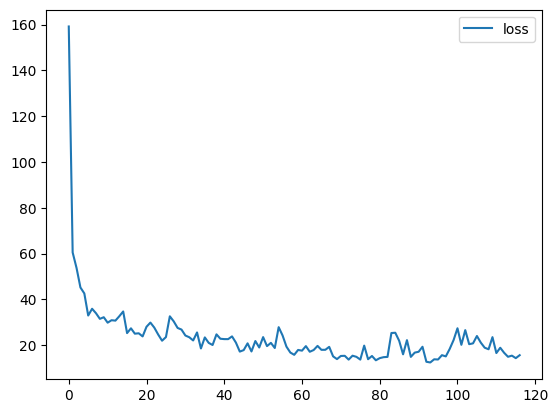

In [47]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot();

15/15 [==============================] - 0s 10ms/step
(455, 10)


/var/folders/y4/8m7zvb3s42z21rz3sv9j00gr0000gn/T/ipykernel_47801/1589627179.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Time_Step'] = np.arange(len(data.index))+start_step


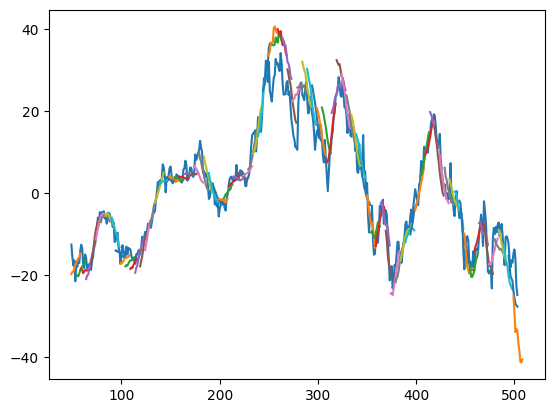

In [59]:
predictions = model.predict(X)
print(predictions.shape)
result_df = add_time_step(y,49)
pred_array = np.array([9,8,7,6,5,4,3,2,1,0])
fig, ax = plt.subplots()
ax.plot(result_df['Time_Step'], result_df['Lag_9'])
for i in range(predictions.shape[0]):
    if i%5 == 0:
        ax.plot(pred_array+i+49,predictions[i])
plt.show()

### 5. Error 

### 6. Testing

In [122]:
test_start_date = '2022-10-31'
test_end_date = '2023-06-30'

test_data = get_data(stock_name,test_start_date,test_end_date)

print(X.iloc[412,:])

test_data.head()

[*********************100%%**********************]  1 of 1 completed
Time_Step    461.000000
Lag_10       -14.985656
Lag_11       -18.967898
Lag_12       -14.310141
Lag_13       -18.912394
Lag_14       -18.224638
Lag_15       -16.736879
Lag_16       -17.019125
Lag_17       -11.631372
Lag_18       -10.613615
Lag_19       -10.865846
Lag_20       -14.468099
Lag_21       -18.670343
Lag_22       -14.342588
Lag_23        -6.934831
Lag_24        -4.967076
Lag_25        -5.909310
Lag_26        -6.201565
Lag_27        -3.843796
Lag_28        -2.816044
Lag_29         0.411705
Lag_30        -1.960537
Lag_31        -5.692780
Lag_32        -3.975025
Lag_33        -0.987266
Lag_34        -2.409511
Lag_35         7.228241
Lag_36         1.216000
Lag_37        -1.646232
Lag_38        -0.098476
Lag_39        -1.480727
Lag_40        -0.152972
Lag_41         2.044793
Lag_42         1.352544
Lag_43         3.090303
Lag_44         5.608060
Lag_45         7.895807
Lag_46        14.353567
Lag_47        11.90

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-31,153.160004,154.240005,151.919998,153.339996,152.235107,97943200
2022-11-01,155.080002,155.449997,149.130005,150.649994,149.564499,80379300
2022-11-02,148.949997,152.169998,145.000000,145.029999,143.985001,93604600
2022-11-03,142.059998,142.800003,138.750000,138.880005,137.879333,97918500
2022-11-04,142.089996,142.669998,134.380005,138.380005,137.610840,140814800


In [123]:
test_data = add_time_step(test_data,412)
test_data = remove_trend1(test_data,trend)
test_data.head()
test_tmp = test_data[['Close','Time_Step']]
for i in range(1,num_lag+num_pred,1):
    create_lag(test_tmp,i)
test_tmp.dropna(inplace=True)
test_X = test_tmp[X_Train_cols]
test_y = test_tmp[y_Train_cols]
test_tmp.head(70)

/var/folders/y4/8m7zvb3s42z21rz3sv9j00gr0000gn/T/ipykernel_47801/1649376569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lag_'+str(i)] = data['Close'].shift(i)
/var/folders/y4/8m7zvb3s42z21rz3sv9j00gr0000gn/T/ipykernel_47801/1649376569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lag_'+str(i)] = data['Close'].shift(i)
/var/folders/y4/8m7zvb3s42z21rz3sv9j00gr0000gn/T/ipykernel_47801/1649376569.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

,Close,Time_Step,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,...,Lag_40,Lag_41,Lag_42,Lag_43,Lag_44,Lag_45,Lag_46,Lag_47,Lag_48,Lag_49
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-11,-24.383217,461,-27.095470,-27.627716,-28.109958,-32.662200,-31.274440,-32.516685,-27.608936,-27.881171,...,-6.262973,-9.045218,-20.997462,-16.319701,-16.851946,-17.344183,-16.796427,-10.598677,-4.930925,-2.193166
2023-01-12,-24.510975,462,-24.383217,-27.095470,-27.627716,-28.109958,-32.662200,-31.274440,-32.516685,-27.608936,...,-7.730727,-6.262973,-9.045218,-20.997462,-16.319701,-16.851946,-17.344183,-16.796427,-10.598677,-4.930925
2023-01-13,-23.208741,463,-24.510975,-24.383217,-27.095470,-27.627716,-28.109958,-32.662200,-31.274440,-32.516685,...,-6.018489,-7.730727,-6.262973,-9.045218,-20.997462,-16.319701,-16.851946,-17.344183,-16.796427,-10.598677
2023-01-17,-22.076489,464,-23.208741,-24.510975,-24.383217,-27.095470,-27.627716,-28.109958,-32.662200,-31.274440,...,-7.316245,-6.018489,-7.730727,-6.262973,-9.045218,-20.997462,-16.319701,-16.851946,-17.344183,-16.796427
2023-01-18,-22.854241,465,-22.076489,-23.208741,-24.510975,-24.383217,-27.095470,-27.627716,-28.109958,-32.662200,...,-5.433994,-7.316245,-6.018489,-7.730727,-6.262973,-9.045218,-20.997462,-16.319701,-16.851946,-17.344183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-17,4.252613,526,4.280380,4.678127,-0.734108,0.013645,1.291397,3.969158,3.116906,5.034672,...,-5.357124,-3.689372,-5.771621,-5.073855,-7.866111,-7.958354,-6.860594,-4.082842,-6.955084,-4.137323
2023-04-18,5.444862,527,4.252613,4.280380,4.678127,-0.734108,0.013645,1.291397,3.969158,3.116906,...,-6.564884,-5.357124,-3.689372,-5.771621,-5.073855,-7.866111,-7.958354,-6.860594,-4.082842,-6.955084
2023-04-19,6.557109,528,5.444862,4.252613,4.280380,4.678127,-0.734108,0.013645,1.291397,3.969158,...,-10.682647,-6.564884,-5.357124,-3.689372,-5.771621,-5.073855,-7.866111,-7.958354,-6.860594,-4.082842


4/4 [==============================] - 0s 10ms/step


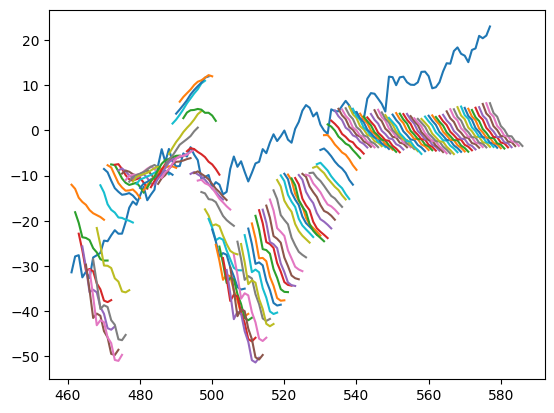

In [125]:
test_predictions = model.predict(test_X)
test_result_df = add_time_step(test_y,461)
pred_array = np.array([9,8,7,6,5,4,3,2,1,0])
fig, ax = plt.subplots()
ax.plot(test_result_df['Time_Step'], test_result_df['Lag_9'])
for i in range(test_predictions.shape[0]):
    ax.plot(pred_array+i+461,test_predictions[i])
plt.show()

In [114]:
print(test_predictions.shape)

(117, 10)
